A.S. Lundervold, version 14.01.23

# Introduction

We want to create a system that can classify pictures of fruit. We'll use the Fruits-360 data set: https://www.kaggle.com/moltean/fruits. 

This is a demo of a mini-project done at the very start of DAT255. Therefore, we'll only use techniques and ideas covered in Module 1 of the course. However, feel free to return to this project later in the course. You'll see that you're then able to bring many additional techniques and tricks to the problem. 

We split the project into three notebooks: 

1. `1.0-asl-collect_and_explore_data.ipynb`: This is the current notebook. Here we'll download and inspect the Fruits-360 data set
2. `2.0-asl-fruit_classifier.ipynb`: Here, we'll design and train our fruit classifier model and evaluate its performance
3. `3.0-asl-fruit_classifer_app.ipynb`: This notebook makes a simple application out of what we've constructed


> <span style="color: green;"> There will be some comments that are a bit different than those one would make if this was a real mini-project completed at the current stage of the course. These are written in green, like this. </span>

# Setup

In [1]:
# This is a quick check of whether the notebook is currently running on Google Colaboratory
# or on Kaggle, as that makes some difference for the code below.
try:
    import colab
    colab=True
except:
    colab=False

import os
kaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

In [2]:
if (colab or kaggle):
    !pip install -Uqq fastbook
    import fastbook
    fastbook.setup_book()
    from fastbook import *
    !pip install kaggle

In [3]:
%matplotlib inline
from fastai.vision.all import *
from pathlib import Path

In [4]:
if colab:
    from google.colab import drive
    drive.mount("/content/gdrive")
    DATA = Path('/content/gdrive/MyDrive/DAT255/fruits-360')
    DATA.mkdir(exist_ok=True, parents=True)
    
elif kaggle:
    # The data is already available on Kaggle and can be added 
    # to the notebook using "+ Add Data".
    DATA = Path('/kaggle/input/fruits')

else:
    # Local installation
    # Set this to where you want to download the image data
    NB_DIR = Path.cwd()       # Set NB_DIR to be the current working directory
    #DATA = NB_DIR/'data'      # The data dir is the subdirectory 'data' under NB_DIR
    DATA = Path("/home/ubuntu/data-tmp/fruits-360")

    DATA.mkdir(exist_ok=True) # Create the data directory

# Get the data

The Fruits-360 data set is available on Kaggle: https://www.kaggle.com/moltean/fruits. 

> We'll use the Kaggle API to download the data. It requires a manual step to download your API Token from Kaggle. See here for instructions https://github.com/Kaggle/kaggle-api. 

If you're using Colab, upload the `kaggle.json` file here:

In [5]:
if colab:
    from google.colab import files
    uploaded = files.upload()
    !mkdir ~/.kaggle
    !cp kaggle.json ~/.kaggle
    !chmod 600 ~/.kaggle/kaggle.json

In [6]:
import os
os.environ['KAGGLE_USERNAME'] = #"<your-kaggle-username>"
os.environ['KAGGLE_KEY'] = #"<your-kaggle-api-key>"

from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [7]:
if not os.path.isfile(DATA/'fruits.zip'):
    api.dataset_download_files('moltean/fruits', path=DATA)

In [8]:
# Warning: on Colab this will take a while. Make sure 
# that the extraction process completes. If not, you may 
# have to retry by removing the "if not ..." check and 
# rerunning the cell
import shutil
if not os.path.exists(DATA/'fruits-360_dataset'):
    shutil.unpack_archive(DATA/'fruits.zip', extract_dir=DATA)

In [9]:
DATA.ls()

(#3) [Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size'),Path('/home/ubuntu/data-tmp/fruits-360/fruits.zip')]

# Basic exploration: what did we just download?

We see that there are two folders that seem to contain the data. We'll have to investigate further to see what we can/should use.

In [10]:
if not (colab or kaggle):
    !tree -L 3 $DATA

/home/ubuntu/data-tmp/fruits-360
├── fruits-360-original-size
│   └── fruits-360-original-size
│       ├── Meta
│       ├── Papers
│       ├── Test
│       ├── Training
│       ├── Validation
│       └── readme.md
├── fruits-360_dataset
│   └── fruits-360
│       ├── LICENSE
│       ├── Test
│       ├── Training
│       ├── papers
│       ├── readme.md
│       └── test-multiple_fruits
└── fruits.zip

13 directories, 4 files


Let's check what's in the `fruits-360_dataset` folder:

In [11]:
(DATA/'fruits-360_dataset').ls()

(#1) [Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360')]

...another folder

In [12]:
(DATA/'fruits-360_dataset'/'fruits-360').ls()

(#6) [Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/LICENSE'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/readme.md'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/papers'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/test-multiple_fruits')]

..we need to dig deeper:

In [13]:
(DATA/'fruits-360_dataset'/'fruits-360'/'Training').ls()

(#131) [Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Tomato Heart'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Cherry 2'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Avocado ripe'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Avocado'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mangostan'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Dates'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Potato Sweet'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Cherry Wax Yellow'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Huckleberry')...]

There we go! Now we seem to have found the images, organized into different classes. 

Let's take a look at a couple:

In [14]:
path = DATA/'fruits-360_dataset'/'fruits-360'

In [15]:
(path/'Training'/'Mango Red').ls()

(#426) [Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red/r_149_100.jpg'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red/r_11_100.jpg'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red/r_255_100.jpg'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red/58_100.jpg'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red/r_179_100.jpg'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red/r_66_100.jpg'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red/80_100.jpg'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red/r_125_100.jpg'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red/156_100.jpg'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-3

Here's one:

In [16]:
test_img = (path/'Training'/'Mango Red').ls()[0]
test_img

Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango Red/r_149_100.jpg')

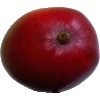

In [17]:
img = load_image(test_img)
img

Let's check its shape

In [18]:
img.shape

(100, 100)

Here are a couple of examples:

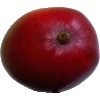

(100, 100)
########################################


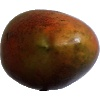

(100, 100)
########################################


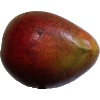

(100, 100)
########################################


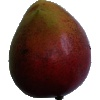

(100, 100)
########################################


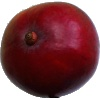

(100, 100)
########################################


In [19]:
for img in (path/'Training'/'Mango Red').ls()[:5]:
    img = load_image(img)
    display(img)
    print(img.shape)
    print("#"*40)

What about the other folder?

In [20]:
DATA.ls()

(#3) [Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size'),Path('/home/ubuntu/data-tmp/fruits-360/fruits.zip')]

In [21]:
(DATA/'fruits-360-original-size').ls()

(#1) [Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size')]

In [22]:
(DATA/'fruits-360-original-size'/'fruits-360-original-size').ls()

(#6) [Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Test'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/readme.md'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Validation'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Meta'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Papers')]

In [23]:
(DATA/'fruits-360-original-size'/'fruits-360-original-size'/'Training').ls()

(#24) [Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_red_1'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_pink_lady_1'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_crimson_snow_1'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_rotten_1'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_red_2'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/pear_3'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_hit_1'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_red_delicios_1'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-

In the `fruits-360_dataset` folder we had more classes than this..

Let's look at a few images and their dimensions:

In [24]:
path = DATA/'fruits-360-original-size'/'fruits-360-original-size'/'Training'

In [25]:
(path/'apple_red_1').ls()

(#309) [Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_red_1/r0_104.jpg'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_red_1/r1_174.jpg'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_red_1/r0_0.jpg'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_red_1/r0_252.jpg'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_red_1/r0_248.jpg'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_red_1/r1_52.jpg'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_red_1/r0_238.jpg'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360-original-size/fruits-360-original-size/Training/apple_red_1/r1_282.jpg'),Path('/home

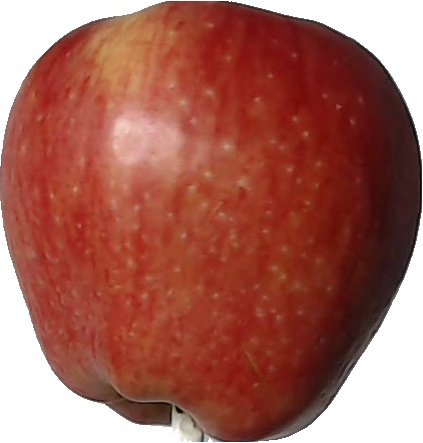

(443, 423)
########################################


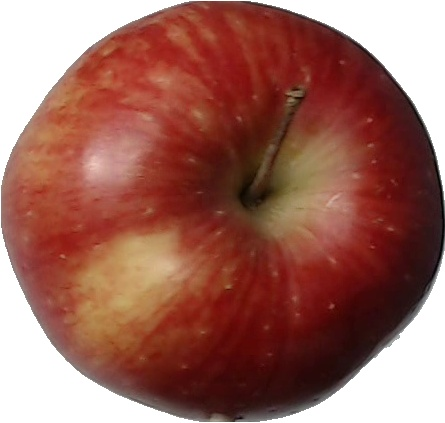

(423, 445)
########################################


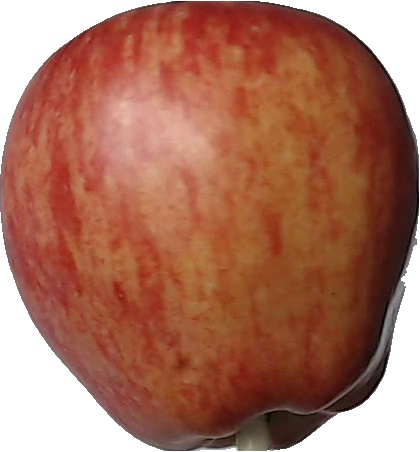

(452, 420)
########################################


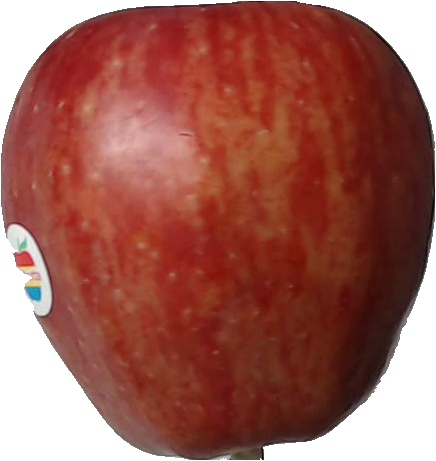

(461, 436)
########################################


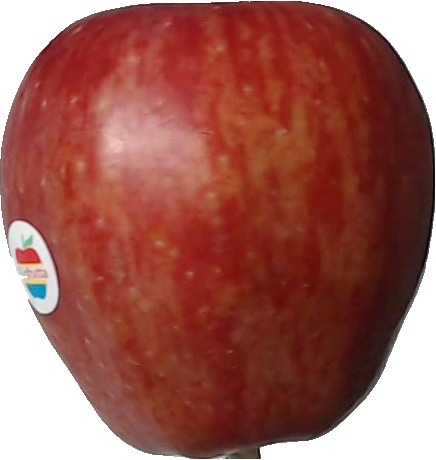

(460, 436)
########################################


In [26]:
for img in (path/'apple_red_1').ls()[:5]:
    img = load_image(img)
    display(img)
    print(img.shape)
    print("#"*40)

Much fewer, but also much larger images, of varying sizes..

> We choose to look at the larger data set of smaller images in what follows. Feel free to explore what you can do with the other data set.

In [27]:
path = DATA/'fruits-360_dataset'/'fruits-360'

# More exploration of the data set

Here are some natural questions that we'd like answered: 

>How many training and test images? How many images of each class of fruit in the two sets? Are all classes represented in both training and test?

In [28]:
path.ls()

(#6) [Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/LICENSE'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/readme.md'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/papers'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/test-multiple_fruits')]

In [29]:
(path/'Training').ls()

(#131) [Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Tomato Heart'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Cherry 2'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Avocado ripe'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Avocado'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mangostan'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Dates'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Potato Sweet'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Mango'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Cherry Wax Yellow'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Training/Huckleberry')...]

In [30]:
(path/'Test').ls()

(#131) [Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test/Tomato Heart'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test/Cherry 2'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test/Avocado ripe'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test/Avocado'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test/Mangostan'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test/Dates'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test/Potato Sweet'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test/Mango'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test/Cherry Wax Yellow'),Path('/home/ubuntu/data-tmp/fruits-360/fruits-360_dataset/fruits-360/Test/Huckleberry')...]

In [31]:
from pathlib import PurePath

In [32]:
def get_class_distribution(path):
    classes = [PurePath(c).parts[-1] for c in path.glob('*')]
    nb_per_class = {c:len(list((path/c).iterdir())) for c in classes}
    
    print(f"There are {len(classes)} classes in the data set")
    
    return nb_per_class

In [33]:
nb_per_class_train = get_class_distribution(path/'Training')

There are 131 classes in the data set


In [34]:
nb_per_class_test = get_class_distribution((path/'Test'))

There are 131 classes in the data set


In [35]:
nb_per_class_train

{'Tomato Heart': 684,
 'Cherry 2': 738,
 'Avocado ripe': 491,
 'Avocado': 427,
 'Mangostan': 300,
 'Dates': 490,
 'Potato Sweet': 450,
 'Mango': 490,
 'Cherry Wax Yellow': 492,
 'Huckleberry': 490,
 'Apple Red Delicious': 490,
 'Pitahaya Red': 490,
 'Pear 2': 696,
 'Kumquats': 490,
 'Potato Red': 450,
 'Eggplant': 468,
 'Salak': 490,
 'Cherry Wax Red': 492,
 'Carambula': 490,
 'Passion Fruit': 490,
 'Tomato 1': 738,
 'Mango Red': 426,
 'Tomato 3': 738,
 'Beetroot': 450,
 'Corn': 450,
 'Rambutan': 492,
 'Onion Red': 450,
 'Lemon': 492,
 'Kiwi': 466,
 'Corn Husk': 462,
 'Apple Red 3': 429,
 'Grape White 2': 490,
 'Grape Blue': 984,
 'Apple Braeburn': 492,
 'Blueberry': 462,
 'Tomato Yellow': 459,
 'Pear Williams': 490,
 'Strawberry': 492,
 'Raspberry': 490,
 'Hazelnut': 464,
 'Grapefruit Pink': 490,
 'Tangelo': 490,
 'Lychee': 490,
 'Orange': 479,
 'Cherry 1': 492,
 'Physalis': 492,
 'Banana Red': 490,
 'Grape White 4': 471,
 'Cucumber Ripe 2': 468,
 'Cucumber Ripe': 392,
 'Banana': 490,

In [36]:
nb_per_class_test

{'Tomato Heart': 228,
 'Cherry 2': 246,
 'Avocado ripe': 166,
 'Avocado': 143,
 'Mangostan': 102,
 'Dates': 166,
 'Potato Sweet': 150,
 'Mango': 166,
 'Cherry Wax Yellow': 164,
 'Huckleberry': 166,
 'Apple Red Delicious': 166,
 'Pitahaya Red': 166,
 'Pear 2': 232,
 'Kumquats': 166,
 'Potato Red': 150,
 'Eggplant': 156,
 'Salak': 162,
 'Cherry Wax Red': 164,
 'Carambula': 166,
 'Passion Fruit': 166,
 'Tomato 1': 246,
 'Mango Red': 142,
 'Tomato 3': 246,
 'Beetroot': 150,
 'Corn': 150,
 'Rambutan': 164,
 'Onion Red': 150,
 'Lemon': 164,
 'Kiwi': 156,
 'Corn Husk': 154,
 'Apple Red 3': 144,
 'Grape White 2': 166,
 'Grape Blue': 328,
 'Apple Braeburn': 164,
 'Blueberry': 154,
 'Tomato Yellow': 153,
 'Pear Williams': 166,
 'Strawberry': 164,
 'Raspberry': 166,
 'Hazelnut': 157,
 'Grapefruit Pink': 166,
 'Tangelo': 166,
 'Lychee': 166,
 'Orange': 160,
 'Cherry 1': 164,
 'Physalis': 164,
 'Banana Red': 166,
 'Grape White 4': 158,
 'Cucumber Ripe 2': 156,
 'Cucumber Ripe': 130,
 'Banana': 166,

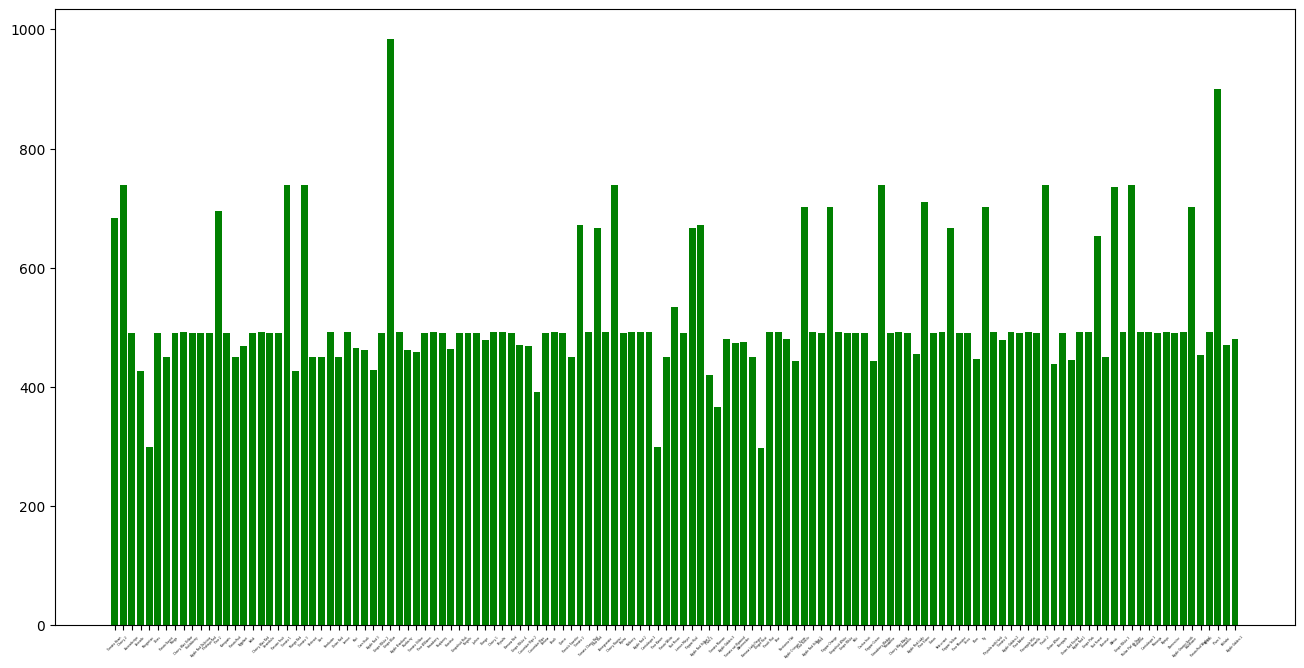

In [37]:
plt.figure(figsize=(16,8))
plt.bar(nb_per_class_train.keys(), nb_per_class_train.values(), color='g')
plt.xticks(rotation=45, fontsize=2)
plt.show()

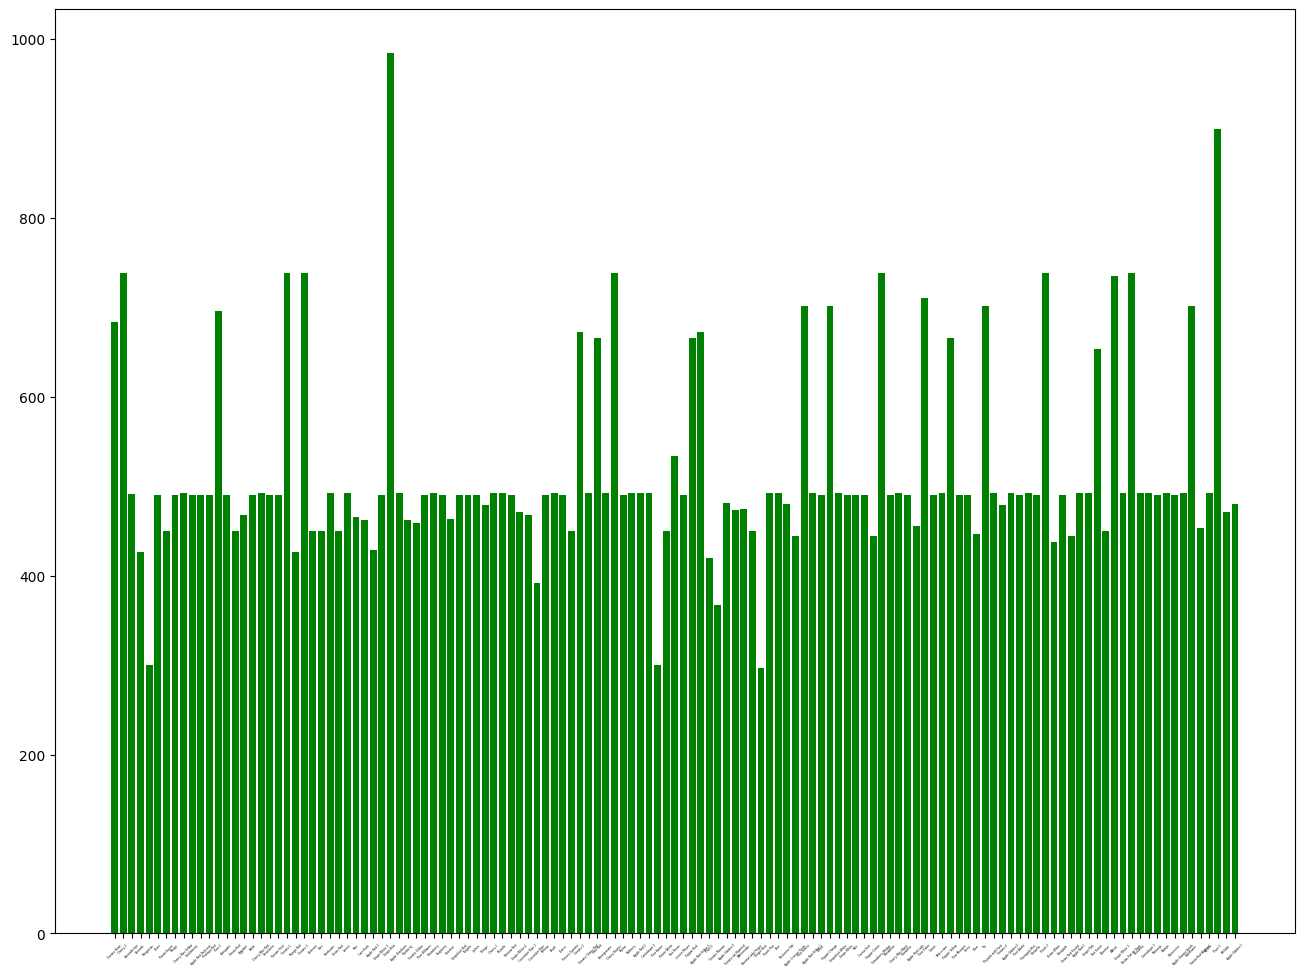

In [38]:
plt.figure(figsize=(16,12))
plt.bar(nb_per_class_test.keys(), nb_per_class_train.values(), color='g')
plt.xticks(rotation=45, fontsize=2)
plt.show()

# What have we learned so far? What's next?

It seems that we can use the data stored in the folder `DATA/fruits-360_dataset/fruits-360`. The labels for each picture of a fruit can be extracted from the name of its parent folder. 

Next: let's turn this into a fastai data set and create fastai data loaders. Then we should be able to train and evaluate a classifier, just as for the image classifiers constructed in Module 1.